# Demo of MAML and Reptile

Code Credits to:
- [Papers-in-100-Lines-of-Code/Model_Agnostic_Meta_Learning_for_Fast_Adaptation_of_Deep_Networks at main · MaximeVandegar/Papers-in-100-Lines-of-Code · GitHub](https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/tree/main/Model_Agnostic_Meta_Learning_for_Fast_Adaptation_of_Deep_Networks)
- [Few-Shot Learning & Meta-Learning in 💯 lines of PyTorch code | MAML algorithm - YouTube](https://www.youtube.com/watch?v=wWZc2ZVTUIE&list=PLgMYKvjKE10XuzMpJOGOu5sxML4TK6r9h&index=3)
- [On First-Order Meta-Learning Algorithms | Reptile in 100 lines of PyTorch code - YouTube](https://www.youtube.com/watch?v=PcA-JRtfan4&list=PLgMYKvjKE10XuzMpJOGOu5sxML4TK6r9h&index=2)

## MAML

MAML is a machine learning algorithm that enables fast adaptation to new tasks with limited data. It works by training a model to quickly adapt to new tasks by learning a good initialization.

The input is the task examples or data point specific to the downstream task.

The output is a set of model initialization parameters.

![maml](../imgs/maml_pseudocode.png)

In [36]:
import copy
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.autograd import grad
from typing import Callable

In [2]:
def mlp(x, params):
    h = torch.relu(torch.nn.functional.linear(x, params[0], bias=params[1]))
    h = torch.relu(torch.nn.functional.linear(h, params[2], bias=params[3]))
    return torch.nn.functional.linear(h, params[4], bias=params[5])

class Task:

    def __init__(self, a, b):
        self.a = a
        self.b = b

    def sample(self, K):
        x = torch.rand((K, 1)) * 10 - 5  # Sample x in [-5, 5]
        y = self.a * torch.sin(x + self.b)
        loss_fct = nn.MSELoss()
        return x, y, loss_fct


@torch.no_grad()
def sample_task():
    a = torch.rand(1).item() * 4.9 + .1  # Sample the amplitude in [0.1, 5.0]
    b = torch.rand(1).item() * np.pi  # Sample the phase in [0, pi]
    return Task(a, b)


def perform_k_training_steps(params, task, batch_size, inner_training_steps, alpha, device='cpu'):
    for epoch in range(inner_training_steps):
        x_batch, target, loss_fct = task.sample(batch_size)
        loss = loss_fct(mlp(x_batch.to(device), params), target.to(device))

        for p in params:  # Zero grad
            p.grad = None
        gradients = grad(loss, params)
        for p, g in zip(params, gradients):  # Grad step
            p.data -= alpha * g
    return params


def maml(p_model, meta_optimizer, inner_training_steps, nb_epochs, batch_size_K, alpha, nb_tasks=10, device='cpu'):
    """
    Algorithm from https://arxiv.org/pdf/1703.03400v3.pdf (MAML for Few-Shot Supervised Learning)
    """
    training_loss = []
    # Line 2 in the pseudocode
    for epoch in tqdm(range(nb_epochs)):  

        theta_i_prime = []
        D_i_prime = []

        # Sample batch of tasks
        # Line 3 in the pseudocode
        tasks = [sample_task() for _ in range(nb_tasks)]  
        # Line 4 in pseudocode
        for task in tasks:
            theta_i_prime.append(perform_k_training_steps([p.clone() for p in p_model], task, batch_size_K,
                                                          inner_training_steps, alpha, device=device))
            # Sample data points Di' for the meta-update (line 8 in the pseudocode)
            x, y, loss_fct = task.sample(25)
            D_i_prime.append((x, y, loss_fct))

        # Meta update
        meta_optimizer.zero_grad()
        batch_training_loss = []
        for i in range(nb_tasks):
            x, y, loss_fct = D_i_prime[i]
            f_theta_prime = theta_i_prime[i]
            # Compute \nabla_theta L(f_theta_i_prime) for task ti
            loss = loss_fct(mlp(x.to(device), f_theta_prime), y.to(device))
            loss.backward()
            batch_training_loss.append(loss.item())

        meta_optimizer.step()  # Line 10 in the pseudocode
        training_loss.append(np.mean(batch_training_loss))
    return training_loss

In [6]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


In [9]:
# line 1: randomly initialize theta using Xavier initialization
params = [torch.rand(40, 1, device=device).uniform_(-np.sqrt(6. / 41), np.sqrt(6. / 41)).requires_grad_(),
          torch.zeros(40, device=device).requires_grad_(),
          torch.rand(40, 40, device=device).uniform_(-np.sqrt(6. / 80), np.sqrt(6. / 80)).requires_grad_(),
          torch.zeros(40, device=device).requires_grad_(),
          torch.rand(1, 40, device=device).uniform_(-np.sqrt(6. / 41), np.sqrt(6. / 41)).requires_grad_(),
          torch.zeros(1, device=device).requires_grad_()]

meta_optimizer = torch.optim.Adam(params, lr=1e-3)

In [12]:
# meta-training process
training_loss = maml(params, meta_optimizer, 1, 30_000, 10, 1e-3, device=device, nb_tasks=10)

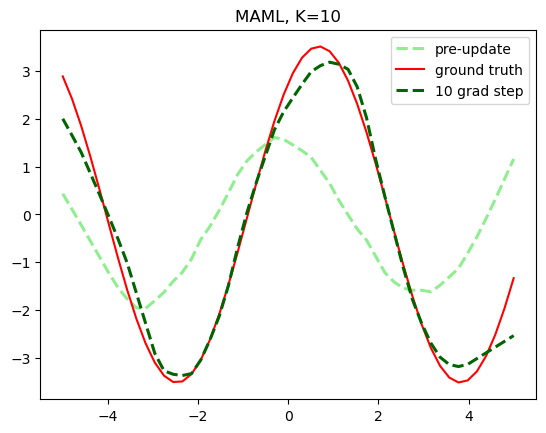

In [11]:
plt.title('MAML, K=10')
x = torch.linspace(-5, 5, 50).to(device)
y = mlp(x[..., None], params)
# plot pre-update
plt.plot(x.data.cpu().numpy(), y.data.cpu().numpy(), c='lightgreen', linestyle='--', linewidth=2.2,
         label='pre-update')
# New task
task = sample_task()
ground_truth_y = task.a * torch.sin(x + task.b)
# plot ground truth
plt.plot(x.data.cpu().numpy(), ground_truth_y.data.cpu().numpy(), c='red', label='ground truth')
# Fine-tuning, 10 gradient steps
new_params = perform_k_training_steps([p.clone() for p in params], task, 10, 10, 1e-3, device=device)
# After 10 gradient steps
y = mlp(x[..., None], new_params)
# plot 10 grad step
plt.plot(x.data.cpu().numpy(), y.data.cpu().numpy(), c='darkgreen', linestyle='--', linewidth=2.2,
         label='10 grad step')
plt.legend()
plt.show()

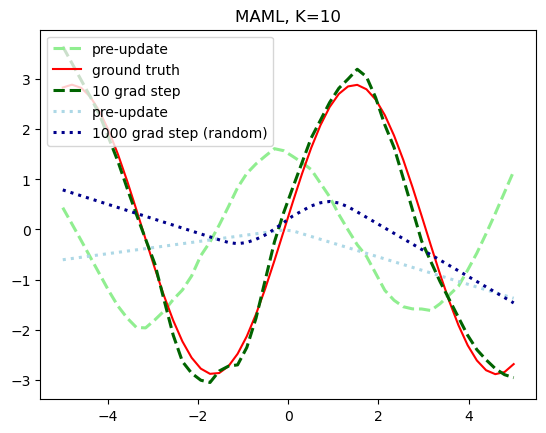

In [31]:
# line 1: randomly initialize theta using Xavier initialization
xavier_init_params = [torch.rand(40, 1, device=device).uniform_(-np.sqrt(6. / 41), np.sqrt(6. / 41)).requires_grad_(),
          torch.zeros(40, device=device).requires_grad_(),
          torch.rand(40, 40, device=device).uniform_(-np.sqrt(6. / 80), np.sqrt(6. / 80)).requires_grad_(),
          torch.zeros(40, device=device).requires_grad_(),
          torch.rand(1, 40, device=device).uniform_(-np.sqrt(6. / 41), np.sqrt(6. / 41)).requires_grad_(),
          torch.zeros(1, device=device).requires_grad_()]


plt.title('MAML, K=10')
x = torch.linspace(-5, 5, 50).to(device)
y = mlp(x[..., None], params)
# plot pre-update
plt.plot(x.data.cpu().numpy(), y.data.cpu().numpy(), c='lightgreen', linestyle='--', linewidth=2.2,
         label='pre-update')
# New task
task = sample_task()
ground_truth_y = task.a * torch.sin(x + task.b)
# plot ground truth
plt.plot(x.data.cpu().numpy(), ground_truth_y.data.cpu().numpy(), c='red', label='ground truth')

# Fine-tuning, 10 gradient steps with meta_trained_params
new_params = perform_k_training_steps([p.clone() for p in params], task, 10, 10, 1e-3, device=device)
# After 10 gradient steps
y = mlp(x[..., None], new_params)
# plot 10 grad step
plt.plot(x.data.cpu().numpy(), y.data.cpu().numpy(), c='darkgreen', linestyle='--', linewidth=2.2,
         label='10 grad step')

y_random = mlp(x[..., None], xavier_init_params)
# plot pre-update
plt.plot(x.data.cpu().numpy(), y_random.data.cpu().numpy(), c='lightblue', linestyle=':', linewidth=2.2,
         label='pre-update')
# Fine-tuning, 10 gradient steps with randomly intialized xavier_init_params
new_params_x = perform_k_training_steps([p.clone() for p in xavier_init_params], task, 10, 1000, 1e-3, device=device)
# After 10 gradient steps
y_random = mlp(x[..., None], new_params_x)
# plot 10 grad step
plt.plot(x.data.cpu().numpy(), y_random.data.cpu().numpy(), c='darkblue', linestyle=':', linewidth=2.2,
         label='1000 grad step (random)')
plt.legend()
plt.show()

In [25]:
import pickle

# Save params using pickle
with open('meta_trained_params.pkl', 'wb') as file:
    pickle.dump(params, file)

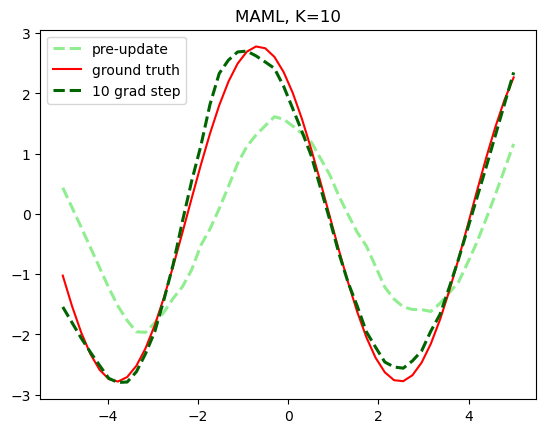

In [ ]:
plt.title('MAML, K=10')
x = torch.linspace(-5, 5, 50).to(device)
y = mlp(x[..., None], params)
# plot pre-update
plt.plot(x.data.cpu().numpy(), y.data.cpu().numpy(), c='lightgreen', linestyle='--', linewidth=2.2,
         label='pre-update')
# New task
task = sample_task()
ground_truth_y = task.a * torch.sin(x + task.b)
# plot ground truth
plt.plot(x.data.cpu().numpy(), ground_truth_y.data.cpu().numpy(), c='red', label='ground truth')
# Fine-tuning, 10 gradient steps
new_params = perform_k_training_steps([p.clone() for p in params], task, 10, 10, 1e-3, device=device)
# After 10 gradient steps
y = mlp(x[..., None], new_params)
# plot 10 grad step
plt.plot(x.data.cpu().numpy(), y.data.cpu().numpy(), c='darkgreen', linestyle='--', linewidth=2.2,
         label='10 grad step')
plt.legend()
plt.show()

In [21]:
print(task.a, task.b)

2.7835754394531254 2.2348012202811063


## Reptile


Reptile repeatedly samples tasks, training a base network on each task for a few iterations, and then aggregating the updates across tasks. It does not require computing second-order derivatives, which eliminates the computational overhead associated with MAML. 


![reptile](../imgs/reptile_pseudocode.png)

In [34]:
class MLP(nn.Module):

    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(MLP, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, noise):
        return self.network(noise)


def reptile(model, nb_iterations: int, sample_task: Callable, perform_k_training_steps: Callable, k=1, epsilon=0.1):
    for _ in tqdm(range(nb_iterations)):

        task = sample_task()
        phi_tilde = perform_k_training_steps(copy.deepcopy(model), task, k)

        # Update phi
        with torch.no_grad():
            for p, g in zip(model.parameters(), phi_tilde):
                p += epsilon * (g - p)


@torch.no_grad()
def sample_task():
    a = torch.rand(1).item() * 4.9 + .1  # Sample a in [0.1, 5.0]
    b = torch.rand(1).item() * 2 * np.pi  # Sample b in [0, 2pi]

    x = torch.linspace(-5, 5, 50)
    y = a * torch.sin(x + b)

    loss_fct = nn.MSELoss()

    return x, y, loss_fct


def perform_k_training_steps(model, task, k, batch_size=10):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

    train_x, train_y, loss_fct = task
    for epoch in range(k * train_x.shape[0] // batch_size):
        ind = torch.randperm(train_x.shape[0])[:batch_size]
        x_batch = train_x[ind].unsqueeze(-1)
        target = train_y[ind].unsqueeze(-1)

        loss = loss_fct(model(x_batch), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Return the new weights after training
    return [p for p in model.parameters()]

In [40]:
model = MLP()
reptile(model, 30000, sample_task, perform_k_training_steps)

with torch.no_grad():
    x = torch.linspace(-5, 5, 50).unsqueeze(-1)
    y_pred_before = model(x)
    new_task = sample_task()
    true_x, true_y, _ = new_task

# Perform 10 training steps on the new task
perform_k_training_steps(model, new_task, 10)
y_pred_after = model(x)



100%|█████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:38<00:00, 782.61it/s]


In [42]:
with open('reptile_model.pkl', 'wb') as file:
    pickle.dump(model, file)

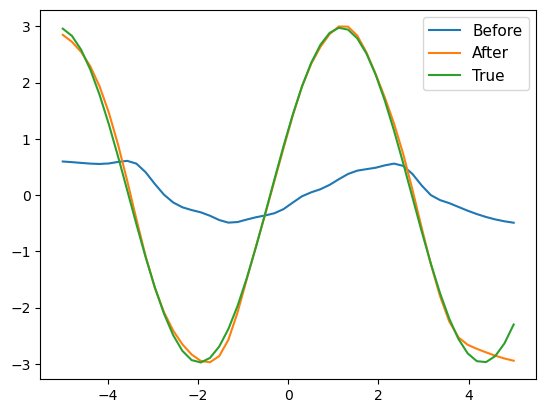

In [41]:
plt.plot(x.numpy(), y_pred_before.numpy(), label='Before')
plt.plot(x.numpy(), y_pred_after.data.numpy(), label='After')
plt.plot(true_x.numpy(), true_y.numpy(), label='True')
plt.legend(fontsize=11)
plt.show()